In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import binom
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta
import statsmodels.api as sm

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Biel/Bienne'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
bassin_lmn = ['Rhône', 'Lac Léman']
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys[dfSurveys.date >= start_date]
dfSurveys['groupname'] = 'nogroup'

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')


In [4]:

group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}
frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}




In [5]:
data = dfSurveys.loc[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)].copy()

def use_apply_meth(x):
    return dfBeaches[dfBeaches.index == x]['water'].values[0]

In [6]:
data['type'] = data.location.apply(use_apply_meth)

In [7]:
data.columns

Index(['date', 'code', 'pcs_m', 'quantity', 'location', 'loc_date',
       'water_name', 'groupname', 'type'],
      dtype='object')

In [8]:
data['type']

0         l
1         l
2         l
3         l
4         l
         ..
131483    r
131484    r
131485    r
131486    r
131487    r
Name: type, Length: 74144, dtype: object

In [9]:
dfBeaches.water_name.unique()

array(['Zurichsee', 'Aare', 'Aare|Nidau-Büren-Kanal', 'Lac Léman', 'Arve',
       'Lago Maggiore', 'Thunersee', 'Untersee', 'Bielersee', 'Birs',
       'Bodensee', 'Ticino', 'Chriesbach', 'Neuenburgersee', 'Emme',
       'Walensee', 'Glatt', 'Goldach', 'Greifensee', 'Grändelbach',
       'Brienzersee', 'Inn', 'Jona', 'Katzensee', 'Dorfbach', 'La Thièle',
       'Langeten', 'Rhône', 'Limmat', 'Linthkanal', 'Escherkanal',
       'Lorze', 'Lötschebach', 'Murg', 'Ognonnaz', 'Pfaffnern', 'Reuss',
       'Rhein', 'Maggia', 'Schiffenensee', 'Schüss', 'Seez', 'Sempachsee',
       'Sense', 'Sihlsee', 'Sihl', 'Sitter', 'Thur', 'Töss', 'Urnäsch',
       'Quatre Cantons', 'Vorderrhein', 'Zugersee', 'Zulg'], dtype=object)

In [10]:
a = ac.PreprocessData(data, dfBeaches,these_cols=these_cols, foams=foams, start_date=start_date, end_date=end_date)

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols)


code maps done
agg foams complet
added exp vs


In [11]:
b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

In [12]:
clas_kwargs.update({'catchment_features':bassin_lmn})
c = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

In [13]:
som_bassin_data = b.bassin_data.copy()
som_bassin_data['fail'] = som_bassin_data.quantity > 0
print(som_bassin_data.columns)

Index(['date', 'code', 'pcs_m', 'quantity', 'location', 'loc_date',
       'water_name', 'groupname', 'type', 'population', 'string_date',
       'region', 'city', 'fail'],
      dtype='object')


In [14]:
# map number of samples per location and sample total of all objects to each record

def add_attribute(x, a_map={}):
    try:
        num_samps = a_map[x]
    except:
        num_samps = 0
    return num_samps

# conut the number of samples per location
num_samp_location = b.bassin_pcsm_day.groupby('location').loc_date.count()

# retrieve the total quantity per sample
qty_sample = b.bassin_pcsm_day.groupby('loc_date').quantity.sum()

In [15]:
# map values to bassin data

# the number of samples at a location
som_bassin_data['nsamps'] = som_bassin_data.location.apply(add_attribute, a_map=num_samp_location)

# the number of samples at a location divided by the total number of samples
som_bassin_data['l_weight'] = som_bassin_data.nsamps/len(som_bassin_data.loc_date.unique())

# the survey total for the corresponding loc_date variable
som_bassin_data['samp_total'] = som_bassin_data.loc_date.map(lambda x: qty_sample[[x]][0])

# the % of total for that object for the survey defined by loc_date
som_bassin_data['% of total'] = som_bassin_data.quantity/som_bassin_data.samp_total

In [16]:
som_bassin_data.loc_date.unique()[:5]

array([('la-petite-plage', '2021-03-12'),
       ('la-petite-plage', '2021-02-15'),
       ('la-petite-plage', '2021-01-16'),
       ('la-petite-plage', '2020-12-14'),
       ('la-petite-plage', '2020-11-15')], dtype=object)

In [17]:
sbd = som_bassin_data.copy()

def save_describe(x):
    data=x.describe()
    return data.values

# save the key values from the original data:
q_before = save_describe(som_bassin_data.quantity)
pc_befor = save_describe(som_bassin_data.pcs_m)
print(som_bassin_data.quantity.sum())

12311


In [18]:
# rank the amplitude of quantity of each code in each survey for all locations
ranked = []

# the loc_date values to aggregate:
locs = som_bassin_data.loc_date.unique()

In [19]:
som_bassin_data.quantity.describe()

count    27500.000000
mean         0.447673
std          3.342633
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        161.000000
Name: quantity, dtype: float64

In [20]:
som_bassin_data.pcs_m.describe()

count    27500.000000
mean         0.010402
std          0.078886
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.230000
Name: pcs_m, dtype: float64

In [21]:
# for each value in loc_date:

for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd[sbd.loc_date == a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
# new data with amplitude rankings for each record
som_bassin_data = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print(q_before == som_bassin_data.quantity.describe().values)
print(som_bassin_data.quantity.sum())
print(pc_befor == som_bassin_data.pcs_m.describe().values)

[ True  True  True  True  True  True  True  True]
12311
[ True False  True  True  True  True  True  True]


In [22]:
# group by code and location. keep the columns that are specific to the location
# agg results: pieces per meter and quantity. count the number of samples for this code and location
sbd_ranked = som_bassin_data.groupby(['code','rank','location', 'population', 'groupname','l_weight'], as_index=False).agg({'pcs_m':'median', 'loc_date':'count', 'quantity':'sum'})

# recalculate the % of total for the group levels
# the sum of this col should equal one
sbd_ranked['% of total'] = sbd_ranked.quantity/sbd_ranked.quantity.sum()

# house keeping
# the number of surveys where this row value would be tru
sbd_ranked.rename(columns={'loc_date':'n_times'}, inplace=True)

# calculate the weight of the sample in reference to all other samples
# the sum of rank_weight should equal one
sbd_ranked['n_weight'] = sbd_ranked.n_times/sbd_ranked.n_times.sum()

print(F"Check the n_weight sum:{sbd_ranked.n_weight.sum()}\n\nCheck the % of total column: {sbd_ranked['% of total'].sum()}\n")

print(F"The number of times that G27 is ranked one: {len(som_bassin_data[(som_bassin_data.code == 'G27')&(som_bassin_data['rank'] == 1)])}\n")

# aggregate and check:
rank_and_code = sbd_ranked.groupby(['rank','code','location'], as_index=False).n_times.sum()
print(F"The aggregated values should be the same: {rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].n_times.sum()}\n")

print(F"The locations where G27 was number one at least once: \n\n{rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].location.unique()}")
print(F"\nG27 has been the number one at least once at {np.round((len(rank_and_code[(rank_and_code.code == 'G27')&(rank_and_code['rank'] == 1)].location.unique())/len(som_bassin_data.location.unique())*100),0)}% of the locations sampled")

print(F"\nG27 has been the number one object at a survey {np.round((len(som_bassin_data[(som_bassin_data.code == 'G27')&(som_bassin_data['rank'] == 1)])/len(som_bassin_data.loc_date.unique()))*100, 0)}% of the time\n" )

Check the n_weight sum:0.9999999999999998

Check the % of total column: 1.0

The number of times that G27 is ranked one: 46

The aggregated values should be the same: 46

The locations where G27 was number one at least once: 

['aare-solothurn-lido-strand' 'aare_brugg_buchie' 'aare_koniz_hoppej'
 'aare_post' 'camping-gwatt-strand' 'evole-plage' 'hafeli'
 'hauterive-petite-plage' 'la-petite-plage' 'mullermatte'
 'plage-de-cheyres' 'ruisseau-de-la-croix-plage' 'schusspark-strand'
 'sundbach-strand' 'thun-strandbad' 'weissenau-neuhaus']

G27 has been the number one at least once at 36.0% of the locations sampled

G27 has been the number one object at a survey 37.0% of the time



In [23]:
other_number_one_ranks = rank_and_code[rank_and_code['rank'] == 1].groupby(['code','location'], as_index=False).n_times.sum()
print(F"Codes and the number of times that they have been the number one item at a survey\n{other_number_one_ranks.groupby('code').n_times.sum().sort_values(ascending=False)}")

Codes and the number of times that they have been the number one item at a survey
code
G27     46
G200    17
G78     11
G30      9
G81      8
G79      7
G67      7
G117     3
G941     2
G98      2
G74      2
G33      1
G213     1
G208     1
G203     1
G201     1
G87      1
G178     1
G146     1
G131     1
G923     1
G112     1
Name: n_times, dtype: int64


In [24]:
# project directory is 'output/bielsummary'
sbd_ranked.to_csv(F"{project_directory}/aare_codes_ranked.csv")

In [25]:
these_codes = ['G27', 'G30','G25', 'G81', 'G95', 'G67','G82']

In [26]:
sbd_ranked_gs = som_bassin_data.groupby(['loc_date','groupname','location', 'population'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

sbd_ranked_gs['% of total'] = sbd_ranked_gs.apply(lambda x: x.quantity/qty_sample[x.loc_date], axis=1)
# save the key values from the original data:
q_before = save_describe(sbd_ranked_gs.quantity)
pc_befor = save_describe(sbd_ranked_gs.pcs_m)
print(sbd_ranked_gs.quantity.sum())

12311


In [27]:
ranked = []
for a_samp in locs:
    sbdl = sbd_ranked_gs[sbd_ranked_gs.loc_date == a_samp].sort_values(by='% of total', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
sbd_ranked_gs = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print("Check that the survey values have not been altered:\n")
print(q_before == sbd_ranked_gs.quantity.describe().values)
print(pc_befor == sbd_ranked_gs.pcs_m.describe().values)

# check the % of total
print(F"\nCheck % of total: {sbd_ranked_gs.groupby('loc_date')['% of total'].sum().sum()}\n")
print(F"The number of SURVEYS where ALL TOBACCO items combined are rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()}\n")

print(F"All TOBACCO items combined were number one in {np.round((sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()/sbd_ranked_gs.loc_date.nunique())*100,0)}% of the surveys.")
print(F"\nThe number of locations that tobaco is rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].location.nunique()}\n")
print(F"The objects labeled tobacco:\n{sbd_ranked[sbd_ranked.groupname == 'tobacco'].code.unique()}")

Check that the survey values have not been altered:

[ True  True False  True  True  True  True  True]
[ True  True  True  True  True  True  True  True]

Check % of total: 125.0

The number of SURVEYS where ALL TOBACCO items combined are rank one: 33

All TOBACCO items combined were number one in 26.0% of the surveys.

The number of locations that tobaco is rank one: 11

The objects labeled tobacco:
['G152' 'G25' 'G26' 'G27']


In [28]:
f = sbd_ranked_gs.groupby(['rank','groupname','location'], as_index=False).loc_date.nunique()
fx = f[f['rank'] == 1].groupby('groupname').loc_date.sum()
print(F"\nThe number of samples: {fx.sum()}\n")
print(F"Other groups and the number of times they have been the most prevalent item:\n{fx.sort_values(ascending=False)}\n")


The number of samples: 125

Other groups and the number of times they have been the most prevalent item:
groupname
food                   45
tobacco                33
fragmented plastics    18
construction           14
agg-con-trans           5
less than 5mm           3
waste water             2
the rest                2
recreation              2
packaging               1
Name: loc_date, dtype: int64



In [29]:
som_params = som_bassin_data[som_bassin_data.quantity > 0].groupby(['location','code','l_weight','% of total'], as_index=False).agg({'pcs_m':'median', '% of total':'median'})
som_params['w_pcsm'] = som_params.l_weight * som_params.pcs_m

som_params[som_params.code == 'G27']

,location,code,l_weight,pcs_m,% of total,w_pcsm
3,aare-limmatspitz,G27,0.008,0.02,0.028571,0.00016
21,aare-solothurn-lido-strand,G27,0.008,1.00,0.407407,0.00800
31,aare_bern_gerberm,G27,0.008,0.19,0.052239,0.00152
49,aare_brugg_buchie,G27,0.008,0.18,0.304348,0.00144
57,aare_koniz_hoppej,G27,0.008,0.09,0.500000,0.00072
...,...,...,...,...,...,...
2622,weissenau-neuhaus,G27,0.080,0.37,0.338346,0.02960
2623,weissenau-neuhaus,G27,0.080,1.42,0.362416,0.11360
2624,weissenau-neuhaus,G27,0.080,0.84,0.364035,0.06720
2625,weissenau-neuhaus,G27,0.080,1.37,0.385621,0.10960


In [30]:
these_codes = ['G27', 'G30','G25', 'G79','G78', 'G95', 'G67','G82', 'G81', 'G89','G35']

In [31]:
these_params = []
for code in these_codes:
    samp_data = som_params[som_params.code == code].pcs_m
    if len(samp_data) < 65:
        samp_data = a.processed[(a.processed.code == code)&(a.processed.quantity > 0)].pcs_m
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    else:
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
#         b_data = som_bassin_data[(som_bassin_data.code == code)&(som_bassin_data.quantity > 0)].pcs_m
    print(code, len(samp_data))
    these_params.append(dict(code=code, loc=loc, alpha=alpha, scale=scale, data=samp_data))


G27 104
G30 100
G25 155
G79 102
G78 92
G95 175
G67 93
G82 177
G81 69
G89 173
G35 143


In [40]:
from statsmodels.graphics.gofplots import qqplot_2samples

In [41]:
plot_this = []
for param in these_params:
    r = gamma.rvs(param['alpha'], loc=param['loc'], scale=param['scale'], size=len(param['data']))
    param.update({'theta_data':r})
    plot_this.append(param)
    

In [44]:
sdata = plot_this[0]

KstestResult(statistic=0.17307692307692307, pvalue=0.08866454800839535)


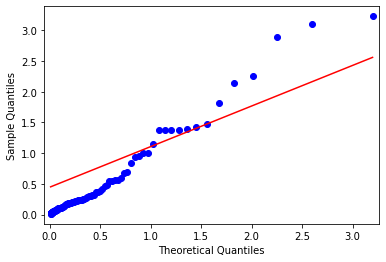

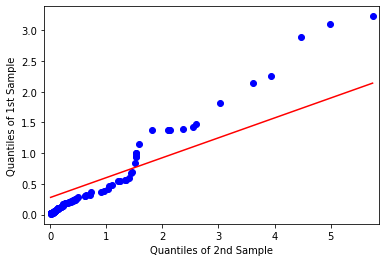

In [46]:
sm.graphics.qqplot(plot_this[0]['data'], gamma, distargs=(plot_this[0]['alpha'],), loc=plot_this[0]['loc'], line='s', fit=False)
qqplot_2samples(sdata['data'], sdata['theta_data'], line='q')
print(stats.ks_2samp(plot_this[0]['data'], plot_this[0]['theta_data']))
plt.show()

plotting G27
plotting G30
plotting G25
plotting G79
plotting G78
plotting G95
plotting G67
plotting G82
plotting G81
plotting G89
plotting G35


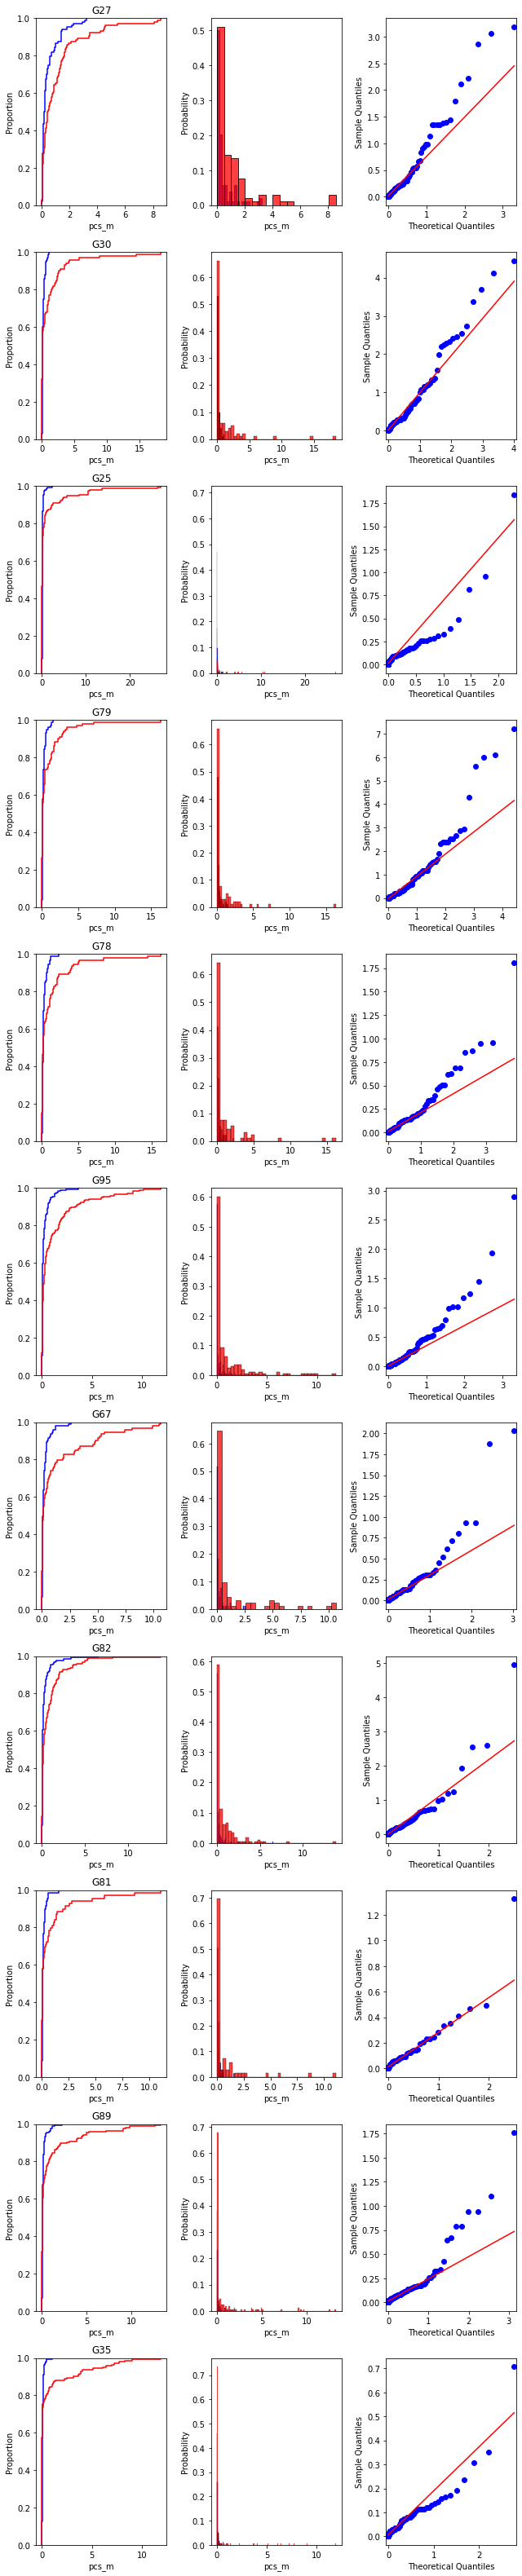

In [39]:
fig, axs = plt.subplots(len(plot_this),3, figsize=(9,len(plot_this)*4))

for i,plot in enumerate(plot_this):
    sns.histplot(plot['data'], ax=axs[i,1], color='blue', stat='probability')
    sns.histplot(plot['theta_data'], ax=axs[i,1], color='red', stat='probability')
    sns.ecdfplot(plot['data'], color='blue', ax=axs[i,0])
    sns.ecdfplot(plot['theta_data'], color='red', ax=axs[i,0])    
    stats.probplot(plot['data'], dist=gamma, sparams=(plot['alpha'], plot['loc']), plot=axs[i,2])
    sm.graphics.qqplot(plot['data'], gamma, distargs=(plot['alpha'],), loc=plot['loc'], scale=plot['scale'], line='q', fit=True, ax=axs[i,2])
    qqplot_2samples(pp_x, pp_y)
    axs[i,0].set_title(plot['code'])
    print(F"plotting {plot['code']}")

plt.tight_layout()
plt.show()

In [36]:
a.processed.groupname.unique()

array(['groupname'], dtype=object)

In [37]:
tries = som_bassin_data.groupby('code').loc_date.nunique()
fails = som_bassin_data.groupby('code').fail.sum()
tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date
asamp = tries_fails.loc[code].rate
grtr_than_zero = som_bassin_data[(som_bassin_data.quantity > 0)].groupby(['code', 'location'], as_index=False).loc_date.count()
som_data = som_bassin_data.copy()
codes_in_use = grtr_than_zero.code.unique()

In [38]:
tir

NameError: name 'tir' is not defined

In [ ]:
grtr_than_zero

In [ ]:
num_obs = som_data.groupby('type', as_index=False).date.count()

In [ ]:
code = 'G81'
data = som_data[(som_data.code == code)&(som_data.quantity > 0)]['pcs_m'].copy()
grtr_than_zero['weight'] = grtr_than_zero.loc_date/grtr_than_zero.loc_date.sum()
print(list(np.cumsum(grtr_than_zero[grtr_than_zero.code == code].weight.values)))

In [ ]:
grtr_than_zero[grtr_than_zero.code == code]

In [ ]:
rate = tries_fails.loc[code].rate
found = binom.rvs(1, rate,size=1)

# this should give a

d_lin = np.linspace(data.min(), data.max(), num=1000, dtype=np.float64)
prior_params = gamma.fit(data[data >0])
print(rate)
print(found)
print(prior_params)

out = gamma.rvs(prior_params[0], loc=prior_params[1], scale=prior_params[2], size=len(d_lin))

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data, ax=ax, color='blue', stat='probability')
sns.histplot(out[out >0], ax=ax, color='red', stat='probability')
plt.show()

In [ ]:
print(data.min(), data.max())

In [ ]:
print(data.median())
print(np.median(out))

In [ ]:
len(codes_in_use)

In [ ]:
this_n = fails.loc[code]
this_p = rate

In [ ]:
tries_fails.loc['G81'].rate

In [ ]:
samples = {}

for i in np.arange(125):

    a_sample = {}
    codes_found = []
    for code in codes_in_use[:20]:
        rate = tries_fails.loc[code].rate
        
        found = binom.rvs(1, rate,size=1)[0]
        if found:
            codes_found.append(code)
    samples.update({i:codes_found})
            
#             data = som_data[(som_data.code == code)]['pcs_m']
#             if len(data) >= 10:
#                 prior_params = gamma.fit(data)
#                 alpha, loc, scale = prior_params
#                 prior_dist = gamma(alpha, loc, scale)
#                 theta_prior = prior_dist.rvs(1)
#                 sum_samples.append({'code':code, 'pcs_m':theta_prior[0], 'date':i})

#             else:
#                 weights = grtr_than_zero[(grtr_than_zero.code == code)].copy()
#                 weights['weight'] = weights.date/weights.date.sum()
#                 theta_prior = choices(weights.pcs_m.values, cum_weights = np.cumsum(weights.weight.values))[0]
#                 sum_samples.append({'code':code, 'pcs_m':theta_prior, 'date':i})
        

In [ ]:
samples[0]

In [ ]:
print([len(v) for k,v in samples.items()])

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch